In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
data = pd.read_csv('HR_data.csv')

# Encode categorical variables
data['Round'] = data['Round'].apply(lambda x: int(x.split('_')[1]))
data['Phase'] = data['Phase'].apply(lambda x: int(x[-1]))

le = LabelEncoder()
data['Puzzler'] = le.fit_transform(data['Puzzler'])
data['Cohort'] = le.fit_transform(data['Cohort'])

# Hr values and frustraion
X = data[['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC', 'Round', 'Phase', 'Puzzler', 'Cohort']]
y = data['Frustrated']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5], y[:5]  # Test

(array([[ 0.26152899,  0.39351481, -0.63365935,  0.82713357, -0.44725716,
         -0.13233303,  0.4472136 ,  1.22474487,  1.        , -0.8660254 ],
        [-0.67230486, -0.52634573, -0.82813559, -0.04311034, -0.85192419,
         -0.41022421,  0.4472136 ,  0.        ,  1.        , -0.8660254 ],
        [-0.35262561, -0.18093376, -0.65380752,  0.06513604, -0.69477195,
         -0.48938678,  0.4472136 , -1.22474487,  1.        , -0.8660254 ],
        [ 0.38877105,  0.37865838, -0.46694313,  0.69752278, -0.32546417,
          0.51981131, -0.4472136 ,  1.22474487,  1.        , -0.8660254 ],
        [ 0.17555954, -0.03360751,  0.00149711,  0.44114977,  0.08548895,
          0.13747606, -0.4472136 ,  0.        ,  1.        , -0.8660254 ]]),
 0    1
 1    5
 2    0
 3    1
 4    5
 Name: Frustrated, dtype: int64)

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_ann():
    model = Sequential()
    model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Initialize and train the ANN model
ann_model = KerasRegressor(build_fn=create_ann, epochs=100, batch_size=10, verbose=0)
ann_model.fit(X_scaled, y)

# Predictions
y_pred_ann = ann_model.predict(X_scaled)

C:\Users\Monza\AppData\Local\Temp\ipykernel_36300\1101547882.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_model = KerasRegressor(build_fn=create_ann, epochs=100, batch_size=10, verbose=0)


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Train models
lr_model.fit(X_scaled, y)
rf_model.fit(X_scaled, y)

# Predictions
y_pred_lr = lr_model.predict(X_scaled)
y_pred_rf = rf_model.predict(X_scaled)
y_pred_ann = ann_model.predict(X_scaled)

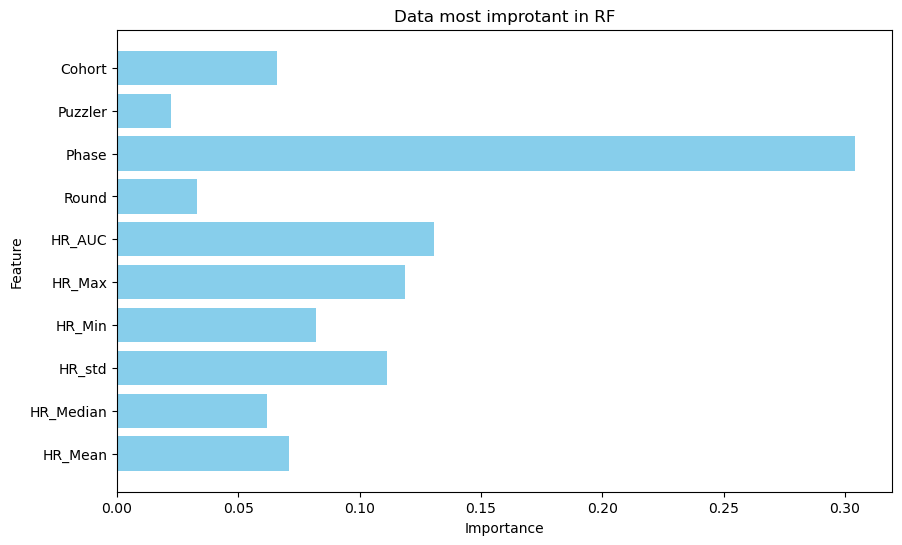

In [4]:
import matplotlib.pyplot as plt

# Get feature importances from Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Data most improtant in RF')
plt.show()

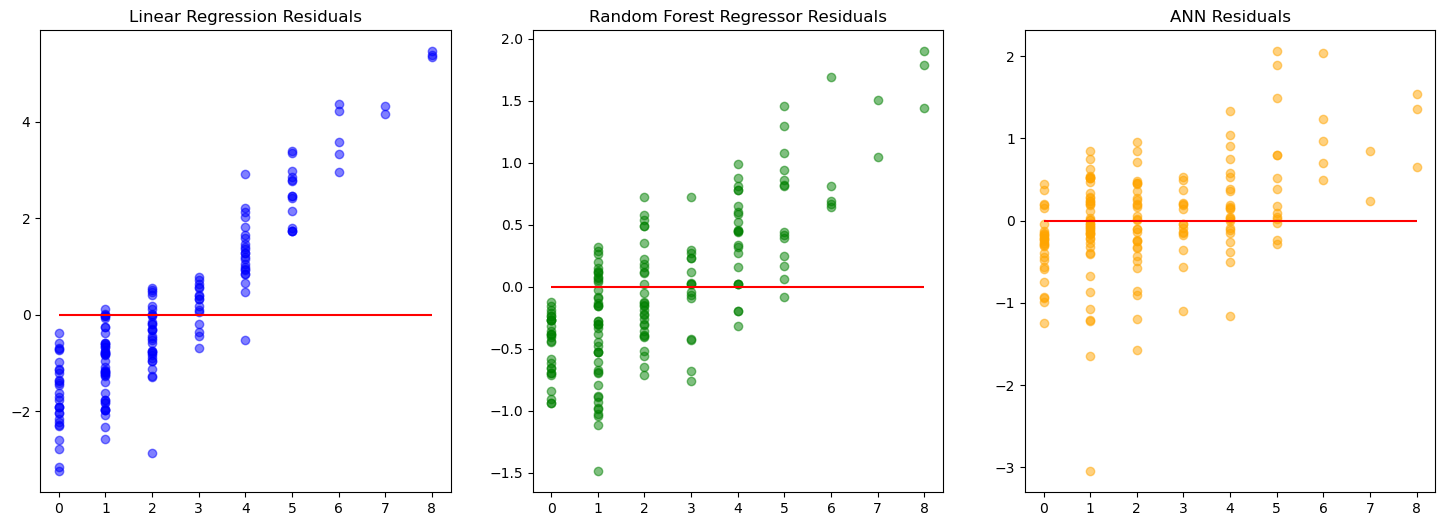

In [5]:
# Plot residuals
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y, y - y_pred_lr, color='blue', alpha=0.5)
plt.hlines(0, min(y), max(y), color='red')
plt.title('Linear Regression Residuals')

plt.subplot(1, 3, 2)
plt.scatter(y, y - y_pred_rf, color='green', alpha=0.5)
plt.hlines(0, min(y), max(y), color='red')
plt.title('Random Forest Regressor Residuals')

plt.subplot(1, 3, 3)
plt.scatter(y, y - y_pred_ann, color='orange', alpha=0.5)
plt.hlines(0, min(y), max(y), color='red')
plt.title('ANN Residuals')

plt.show()

In [6]:
from sklearn.model_selection import GroupKFold

# Features and target
X = data[['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC', 'Round', 'Phase', 'Puzzler', 'Cohort']]
y = data['Frustrated']
groups = data['Individual']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Evaluate models with GroupKFold cross-validation
def evaluate_model_with_groupkfold(model, X, y, groups, gkf):
    mae_scores = cross_val_score(model, X, y, groups=groups, cv=gkf, scoring='neg_mean_absolute_error')
    mse_scores = cross_val_score(model, X, y, groups=groups, cv=gkf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, groups=groups, cv=gkf, scoring='r2')
    return -mae_scores.mean(), -mse_scores.mean(), r2_scores.mean()

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
ann_model = KerasRegressor(build_fn=create_ann, epochs=100, batch_size=10, verbose=0)

# Evaluate models
lr_mae, lr_mse, lr_r2 = evaluate_model_with_groupkfold(lr_model, X_scaled, y, groups, gkf)
rf_mae, rf_mse, rf_r2 = evaluate_model_with_groupkfold(rf_model, X_scaled, y, groups, gkf)
ann_mae, ann_mse, ann_r2 = evaluate_model_with_groupkfold(ann_model, X_scaled, y, groups, gkf)

# Print model performance metrics
print(f"Linear Regression: MAE = {lr_mae:.2f}, MSE = {lr_mse:.2f}, R² = {lr_r2:.2f}")
print(f"Random Forest Regressor: MAE = {rf_mae:.2f}, MSE = {rf_mse:.2f}, R² = {rf_r2:.2f}")
print(f"ANN: MAE = {ann_mae:.2f}, MSE = {ann_mse:.2f}, R² = {ann_r2:.2f}")

C:\Users\Monza\AppData\Local\Temp\ipykernel_36300\1218636425.py:25: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_model = KerasRegressor(build_fn=create_ann, epochs=100, batch_size=10, verbose=0)


Linear Regression: MAE = 1.56, MSE = 4.03, R² = -0.17
Random Forest Regressor: MAE = 1.46, MSE = 3.27, R² = -0.07
ANN: MAE = 1.69, MSE = 5.19, R² = -0.65


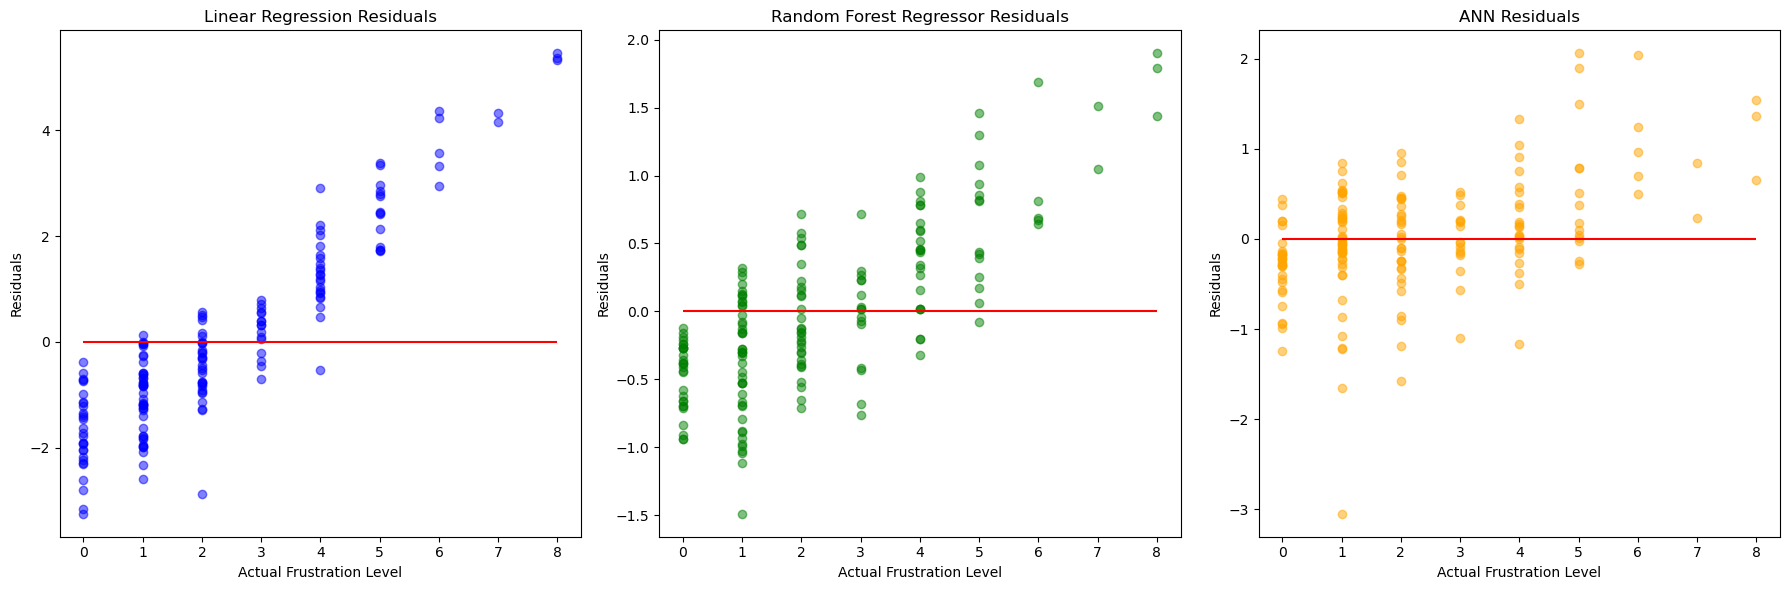

In [10]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y, y - y_pred_lr, color='blue', alpha=0.5)
plt.hlines(0, min(y), max(y), color='red')
plt.xlabel('Actual Frustration Level')
plt.ylabel('Residuals')
plt.title('Linear Regression Residuals')

plt.subplot(1, 3, 2)
plt.scatter(y, y - y_pred_rf, color='green', alpha=0.5)
plt.hlines(0, min(y), max(y), color='red')
plt.xlabel('Actual Frustration Level')
plt.ylabel('Residuals')
plt.title('Random Forest Regressor Residuals')

plt.subplot(1, 3, 3)
plt.scatter(y, y - y_pred_ann, color='orange', alpha=0.5)
plt.hlines(0, min(y), max(y), color='red')
plt.xlabel('Actual Frustration Level')
plt.ylabel('Residuals')
plt.title('ANN Residuals')

plt.tight_layout()
plt.show()

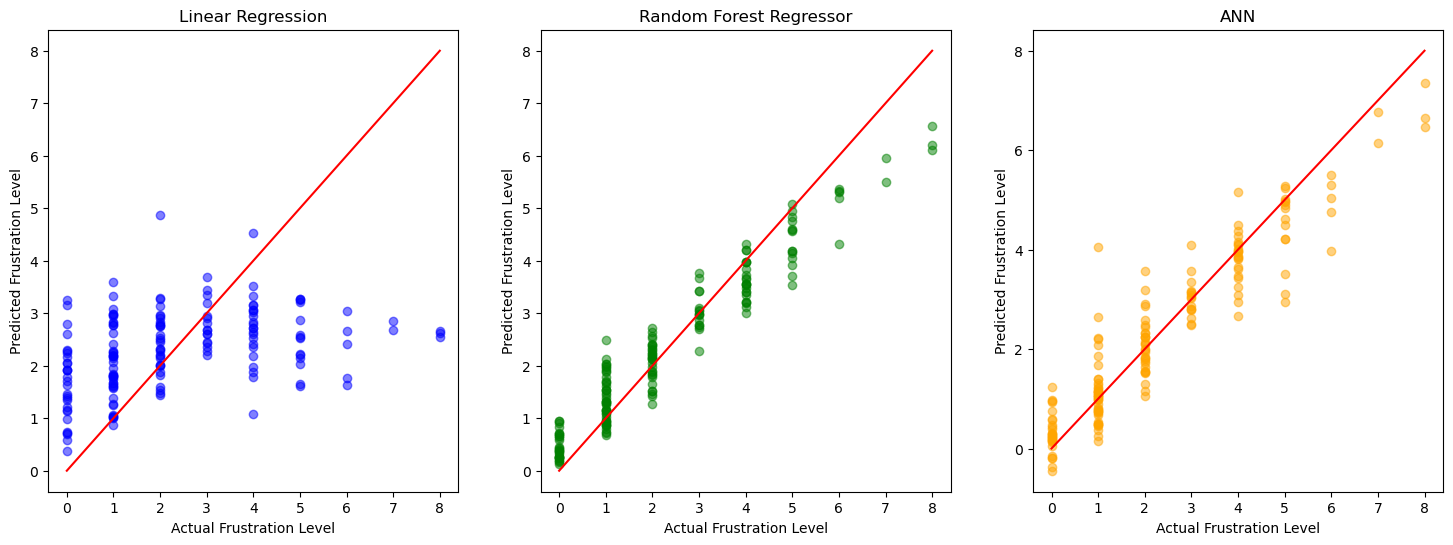

In [9]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(y, y_pred_lr, color='blue', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')
plt.xlabel('Actual Frustration Level')
plt.ylabel('Predicted Frustration Level')
plt.title('Linear Regression')

plt.subplot(1, 3, 2)
plt.scatter(y, y_pred_rf, color='green', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')
plt.xlabel('Actual Frustration Level')
plt.ylabel('Predicted Frustration Level')
plt.title('Random Forest Regressor')

plt.subplot(1, 3, 3)
plt.scatter(y, y_pred_ann, color='orange', alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')
plt.xlabel('Actual Frustration Level')
plt.ylabel('Predicted Frustration Level')
plt.title('ANN')

plt.show()

In [56]:
from tabulate import tabulate

# Create a table
metrics = [
    ['Linear Regression', lr_mae, lr_mse, lr_r2],
    ['Random Forest Regressor', rf_mae, rf_mse, rf_r2],
    ['ANN', ann_mae, ann_mse, ann_r2]
]

print(tabulate(metrics, headers=['Model', 'MAE', 'MSE', 'R_squared']))

Model                        MAE      MSE    R_squared
-----------------------  -------  -------  -----------
Linear Regression        1.56487  4.0253    -0.172661
Random Forest Regressor  1.45631  3.27173   -0.0692814
ANN                      1.62008  4.79673   -0.481657
